# Walk-forward moving averages strategy

This notebook uses backtesting module to perform a walk-forward test on the moving averages strategy.

Populating the interactive namespace from numpy and matplotlib
Got 3798 days of data


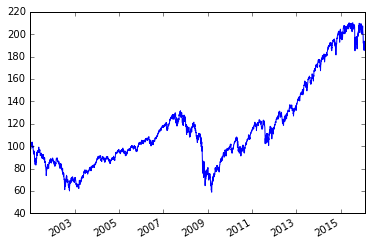

In [3]:
%pylab inline

# start with getting some data to test on
import tradingWithPython as twp # main toolkit functions
import tradingWithPython.lib.yahooFinance as yf # yahoo finance module
import tradingWithPython.lib.backtest as backtest
import pandas as pd

symbol = 'SPY'
price = yf.getHistoricData(symbol,sDate = (2001,1,1))['adj_close'] # get adj_close data

price.plot()

It is convenient to put all strategy functions and data into a class to make it more 'portable'.
One thing that requires special care is walk-forwad testing. I'd like to simulate optimizing the strat on 2-year data and using optimal parameters to trade for 1 year.

Optimizing...
 [*********************100%***********************]  18 of 18 complete 
Best periods: [75, 9] (sharpe: 0.51)


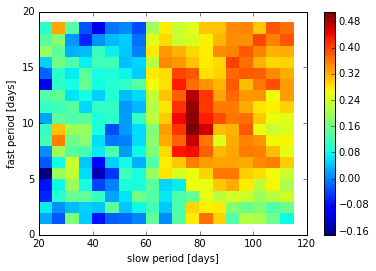

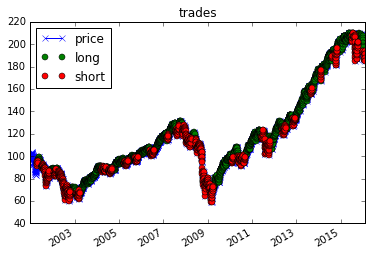

In [4]:
# create a strategy class (based on code from twp_302)


class MovingAvg(object):
    ''' moving averages strategy '''
    def __init__(self,price, periods=[50,10]):
        '''
        Parameters:
        *price* Series with price
        *periods* [slowMaPeriod,fastMaPeriod] - periods for moving averages
        '''
       
        self.price = price
        self.periods = periods # periods can be changed later, manually or by the optimizer 
        
    def simulate(self,bet=10000,plotOn=False):
        ''' 
        simulate strategy 
        Parameters:
        *bet* amount to bet each trade, in $
        *plotOn*  create plot trades
        
        '''
        
        maSlow = pd.rolling_mean(self.price,self.periods[0]) # slow moving average
        maFast = pd.rolling_mean(self.price,self.periods[1]) # fast moving average
        
        pos = pd.Series(index = self.price.index) # init position series
        
        pos[maFast>maSlow] = bet # go long when maFast>maSlow
        pos[maFast<=maSlow] = -bet # go short when maFast<maSlow
        
        self.backtest = backtest.Backtest(self.price,pos,signalType='capital') # note the difference between variable and module 'backtest'
        
        if plotOn: 
            figure()
            self.backtest.plotTrades()
   
   
    def optimize(self,fastPeriod = arange(1,20,1),slowPeriod = arange(20,120,5),plotOn =False , outOfSample = 0):
        ''' 
        make a parameter scan 
        Parameters
        *fastPeriod* scan range fast ma
        *slowPeriod* scan range slow ma
        *plotOn* create heatmap plot after optimizing
        *outOfSample* number of days at the end of dataset to exclude from optimization. Used for walk-forward testing
        
        '''
        
        print('Optimizing...')
        SH = np.zeros((len(fastPeriod),len(slowPeriod)))
        pBar = backtest.ProgressBar(len(fastPeriod)-1)
        #pBar = twp.lib.extra.ProgressBar(len(fastPeriod)-1)

        for i, f in enumerate(fastPeriod):
            pBar.animate(i)
            
            for j, s in enumerate(slowPeriod):
                self.periods = [s,f] # set periods parameter
                self.simulate()
                self.backtest.pnl[-(outOfSample-1):] = np.nan # set last samples to nan to exclude them from sharpe calculation
                SH[i,j] = self.backtest.sharpe
  
        i,j = np.unravel_index(SH.argmax(), SH.shape) # find index of optimum values. .
        self.periods = [slowPeriod[j],fastPeriod[i]] # it's easy to mix up i and j                                  
            
        print('\nBest periods: %s (sharpe: %.2f)' % (str(self.periods), SH[i,j]  ))      
        
        if plotOn:
            figure()
            pcolor(slowPeriod,fastPeriod, SH)
            ylabel('fast period [days]')
            xlabel('slow period [days]');
            colorbar();
            
    
    
    def __repr__(self):
        return 'Moving Averages strategy slowMa=%i,fastMa=%i' % (self.periods[0],self.periods[1])



strat = MovingAvg(price)
strat.optimize(plotOn=True, outOfSample=250)

strat.simulate(plotOn=True) # resimulate with optimal parameters

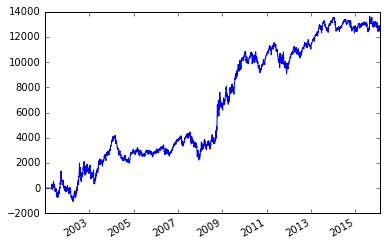

In [5]:
strat.backtest.pnl.plot()

## Run walk-forward simulation##
process data in 3-year blocks, 2 years for optimization, 1 year for out-of-sample test. I did not split the datasets to in-sample and out-of-sample for convenience (moving averages need some extra samples at the beginning of the dataset), so caution is advised regarding the look-ahead bias.

In [8]:
step = 250 # forward test step in days (250 trading days = 1 year)
results = [] # list to save backtest results in

for idx in range(step*3,len(price),step): # step through price in steps of 250 . Note that the test will probably not include 
    # last part of the price dataset because we are starting from the beginning and there price length is not exact multiple of 250
   
    p = price[idx-step*3:idx] # price dataset to use in this iteration. first 2/3 is in-sample last 1/3 is out-of-sample
    print('Using price data in range' , p.index[0].date() , p.index[-1].date())
    
   
    # do the math...
    strat = MovingAvg(p)
    strat.optimize(plotOn=False, outOfSample=250)

    strat.simulate(plotOn=False) # resimulate with optimal parameters
    results.append(strat.backtest.pnl.diff()[-250:]) # note the diff, transforming back from cumulative to daily pnl
    

Using price data in range 2001-01-02 2003-12-29
Optimizing...
 [*********************100%***********************]  18 of 18 complete 
Best periods: [25, 7] (sharpe: 1.29)
Using price data in range 2002-01-04 2004-12-27
Optimizing...
 [*********************100%***********************]  18 of 18 complete 
Best periods: [70, 13] (sharpe: 1.46)
Using price data in range 2003-01-02 2005-12-21
Optimizing...
 [*********************100%***********************]  18 of 18 complete 
Best periods: [60, 14] (sharpe: 1.47)
Using price data in range 2003-12-30 2006-12-19
Optimizing...
 [*********************100%***********************]  18 of 18 complete 
Best periods: [20, 15] (sharpe: 0.42)
Using price data in range 2004-12-28 2007-12-18
Optimizing...
 [*********************100%***********************]  18 of 18 complete 
Best periods: [70, 9] (sharpe: 1.09)
Using price data in range 2005-12-22 2008-12-15
Optimizing...
 [*********************100%***********************]  18 of 18 complete 
Best per

[0] 2003-01-02 2003-12-29
[1] 2003-12-30 2004-12-27
[2] 2004-12-28 2005-12-21
[3] 2005-12-22 2006-12-19
[4] 2006-12-20 2007-12-18
[5] 2007-12-19 2008-12-15
[6] 2008-12-16 2009-12-11
[7] 2009-12-14 2010-12-09
[8] 2010-12-10 2011-12-06
[9] 2011-12-07 2012-12-05
[10] 2012-12-06 2013-12-03
[11] 2013-12-04 2014-12-01
[12] 2014-12-02 2015-11-27


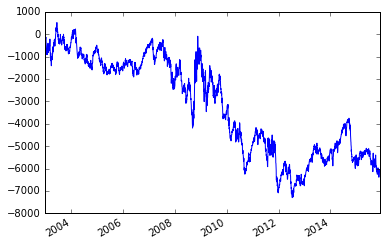

In [9]:
# before combining results, check if their date ranges are according to expectations (these should be contigious)
for i,r in enumerate(results):
    print('[%i]' % i , r.index[0].date() , r.index[-1].date())

# concatenate results to one series and plot
pnl = pd.concat(results)
pnl.cumsum().plot()

...that does not look good at all. Even without transaction costs and slippage the strategy loses money.